In [20]:
import json
from collections import Counter
from keras.models import Model
from keras.layers import Embedding, Input, Reshape
from keras.layers.merge import Dot
from sklearn.linear_model import LinearRegression
import numpy as np
import random
from sklearn import svm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
with open('data/wp_movies_10k.ndjson') as fin:
    movies = [json.loads(l) for l in fin]

In [3]:
link_counts = Counter()
for movie in movies:
    link_counts.update(movie[2])
link_counts.most_common(10)

[('Rotten Tomatoes', 9393),
 ('Category:English-language films', 5882),
 ('Category:American films', 5867),
 ('Variety (magazine)', 5450),
 ('Metacritic', 5112),
 ('Box Office Mojo', 4186),
 ('The New York Times', 3818),
 ('The Hollywood Reporter', 3553),
 ('Roger Ebert', 2707),
 ('Los Angeles Times', 2454)]

In [10]:
movies[1][0]

'The Revenant (2015 film)'

In [11]:
movies[1][1]

{'image': 'The Revenant 2015 film poster.jpg',
 'name': 'The Revenant',
 'cinematography': 'Emmanuel Lubezki',
 'language': 'English',
 'distributor': '20th Century Fox',
 'caption': 'Theatrical release poster',
 'gross': '$533 million',
 'country': 'United States',
 'director': 'Alejandro G. Iñárritu',
 'budget': '$135 million',
 'editing': 'Stephen Mirrione',
 'runtime': '156 minutes'}

In [6]:
movies[1][2]

['Alejandro González Iñárritu',
 'Arnon Milchan',
 'Steve Golin',
 'Mary Parent',
 'Keith Redmon',
 'James W. Skotchdopole',
 'Mark L. Smith',
 'The Revenant (novel)',
 'Michael Punke',
 'Leonardo DiCaprio',
 'Tom Hardy',
 'Domhnall Gleeson',
 'Will Poulter',
 'Ryuichi Sakamoto',
 'Alva Noto',
 'Emmanuel Lubezki',
 'Stephen Mirrione',
 '20th Century Fox',
 'TCL Chinese Theatre',
 'British Board of Film Classification',
 'TheWrap',
 'Box Office Mojo',
 'Regency Enterprises',
 'RatPac-Dune Entertainment',
 'Anonymous Content',
 'Appian Way Productions',
 'Biographical film',
 'Business Insider',
 'Western (genre)',
 'Alejandro González Iñárritu',
 'Mark L. Smith',
 'Michael Punke',
 'The Revenant (novel)',
 'frontiersman',
 'Hugh Glass',
 'Leonardo DiCaprio',
 'Tom Hardy',
 'Domhnall Gleeson',
 'Will Poulter',
 'Akiva Goldsman',
 'Principal photography',
 'TCL Chinese Theatre',
 'limited release',
 'wide release',
 'cinematography',
 'Golden Globe Awards',
 'BAFTA Awards',
 '88th Academy

In [18]:
top_links = [link for link, c in link_counts.items() if c >= 3]
link_to_idx = {link: idx for idx, link in enumerate(top_links)}
idx_to_link = {idx: link for link, idx in link_to_idx.items()}

movie_to_idx = {movie[0]: idx for idx, movie in enumerate(movies)}
idx_to_movie = {idx: movie for movie, idx in movie_to_idx.items()}

pairs = []
for movie in movies:
    pairs.extend((link_to_idx[link], movie_to_idx[movie[0]]) for link in movie[2] if link in link_to_idx)
pairs_set = set(pairs)
len(pairs), len(top_links), len(movie_to_idx)

(949544, 66913, 10000)

In [21]:
pairs[1]

idx_to_link[1]
idx_to_movie[0]

(1, 0)

'Simon Kinberg'

'Deadpool (film)'

In [26]:
pairs[1000]
idx_to_link[564]
idx_to_movie[3]

(564, 3)

'Hoyte van Hoytema'

'Spectre (2015 film)'

In [27]:
def movie_embedding_model(embedding_size=50):
    link = Input(name='link', shape=(1,))
    movie = Input(name='movie', shape=(1,))
    link_embedding = Embedding(name='link_embedding', 
                               input_dim=len(top_links), 
                               output_dim=embedding_size)(link)
    movie_embedding = Embedding(name='movie_embedding', 
                                input_dim=len(movie_to_idx), 
                                output_dim=embedding_size)(movie)
    dot = Dot(name='dot_product', normalize=True, axes=2)([link_embedding, movie_embedding])
    merged = Reshape((1,))(dot)
    model = Model(inputs=[link, movie], outputs=[merged])
    model.compile(optimizer='nadam', loss='mse')
    return model

model = movie_embedding_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
link (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 50)        3345650     link[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        500000      movie[0][0]                      
__________________________________________________________________________________________________
dot_produc

In [29]:
random.seed(5)

def batchifier(pairs, positive_samples=50, negative_ratio=10):
    """Generate batches of positive and negative samples"""
    batch_size = positive_samples * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    # Generator yields batches
    while True:
        # Sample random positive samples
        for idx, (link_id, movie_id) in enumerate(random.sample(pairs, positive_samples)):
            # The labels for these samples are positive (1)
            batch[idx, :] = (link_id, movie_id, 1)
        idx = positive_samples
        
        # Continue adding negative samples until batch size is reached
        while idx < batch_size:
            # Sample a random movie
            movie_id = random.randrange(len(movie_to_idx))
            # Sample a random link
            link_id = random.randrange(len(top_links))
            # If the link is not on the movie page, this is a negative sample
            if not (link_id, movie_id) in pairs_set:
                # Set the label as negative (-1)
                batch[idx, :] = (link_id, movie_id, -1)
                idx += 1
        # Make sure to shuffle the order of the positive and negative samples
        np.random.shuffle(batch)
        # Yield the links, movies, and labels
        yield {'link': batch[:, 0], 'movie': batch[:, 1]}, batch[:, 2]

next(batchifier(pairs, positive_samples=3, negative_ratio=2))

({'link': array([20558.,  3801.,  1313., 32643., 22418., 32318., 13365., 31254.,
         48731.]),
  'movie': array([ 849., 5874., 7236., 7628., 1529., 7685., 6238., 5530., 1854.])},
 array([-1., -1.,  1., -1.,  1., -1., -1.,  1., -1.]))

In [30]:
positive_samples_per_batch = 512

# Fit the model to samples from the generator
model.fit_generator(
    batchifier(pairs, positive_samples=positive_samples_per_batch, negative_ratio=10),
    epochs=15,
    # Number of batches to grab every epoch
    steps_per_epoch=len(pairs) // positive_samples_per_batch,
    verbose=2
)

Epoch 1/15
 - 86s - loss: 0.4376
Epoch 2/15
 - 86s - loss: 0.2994
Epoch 3/15
 - 87s - loss: 0.2938
Epoch 4/15
 - 86s - loss: 0.2916
Epoch 5/15
 - 86s - loss: 0.2880
Epoch 6/15
 - 81s - loss: 0.2809
Epoch 7/15
 - 86s - loss: 0.2870
Epoch 8/15
 - 88s - loss: 0.2846
Epoch 9/15
 - 86s - loss: 0.2830
Epoch 10/15
 - 87s - loss: 0.2844
Epoch 11/15
 - 79s - loss: 0.2773
Epoch 12/15
 - 88s - loss: 0.2831
Epoch 13/15
 - 86s - loss: 0.2829
Epoch 14/15
 - 87s - loss: 0.2828
Epoch 15/15
 - 86s - loss: 0.2821


In [40]:
movie = model.get_layer('movie_embedding')
movie_weights = movie.get_weights()[0]
movie_lengths = np.linalg.norm(movie_weights, axis=1)
normalized_movies = (movie_weights.T / movie_lengths).T

def similar_movies(movie):
    dists = np.dot(normalized_movies, normalized_movies[movie_to_idx[movie]])
    closest = np.argsort(dists)[-10:]
    for c in reversed(closest):
        print(c, 'Movie:', movies[c][0], 'Rating:', movies[c][-1], 'Distance:', dists[c])
    return dists

d = similar_movies('Rogue One')

29 Movie: Rogue One Rating: 7.5/10 Distance: 0.99999994
19 Movie: Interstellar (film) Rating:  Distance: 0.9625172
245 Movie: Gravity (film) Rating: None Distance: 0.95995843
25 Movie: Star Wars sequel trilogy Rating: None Distance: 0.9586152
659 Movie: Rise of the Planet of the Apes Rating: 7.1/10 Distance: 0.9524014
3349 Movie: Star Wars: The Force Awakens Rating: None Distance: 0.9453219
38 Movie: Ex Machina (film) Rating:  Distance: 0.9423549
62 Movie: Fantastic Beasts and Where to Find Them (film) Rating: 6.8/10 Distance: 0.94203746
160 Movie: Jupiter Ascending Rating: 4.3/10 Distance: 0.9416374
86 Movie: Tomorrowland (film) Rating: 5.9/10 Distance: 0.94101655


In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 10, verbose = 1).fit_transform(normalized_movies)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.019s...
[t-SNE] Computed neighbors for 10000 samples in 9.437s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.060939
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.835037
[t-SNE] Error after 1000 iterations: 2.050180


In [61]:
ratings = [int(r[3][:-1]) if r[3] is not None else np.nan for r in movies]

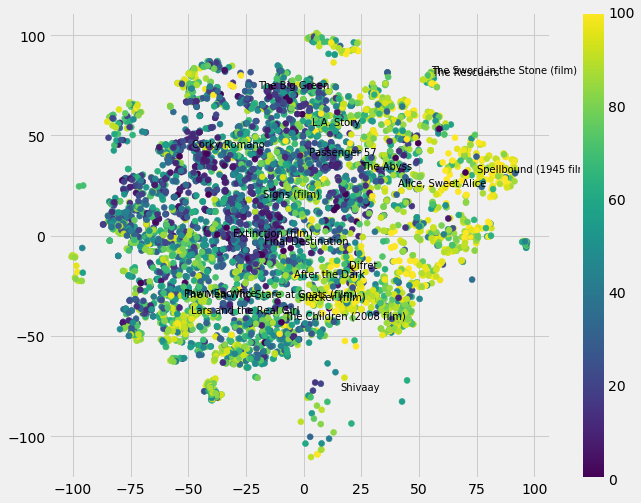

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

xs = tsne[:, 0]
ys = tsne[:, 1]

plt.figure(figsize = (10, 8))
plt.scatter(xs, ys, c = ratings)

plot_movies = random.sample(movie_to_idx.keys(), 20)

for m in plot_movies:
    index = movie_to_idx[m]
    plt.text(x = tsne[index, 0], y = tsne[index, 1], s = m, fontsize = 10);
    
plt.colorbar();

In [65]:
link_counts

Counter({'Tim Miller (director)': 9,
         'Simon Kinberg': 33,
         'Ryan Reynolds': 114,
         'Lauren Shuler Donner': 37,
         'Rhett Reese': 12,
         'Paul Wernick': 11,
         'Deadpool': 9,
         'Fabian Nicieza': 1,
         'Rob Liefeld': 2,
         'Morena Baccarin': 16,
         'Ed Skrein': 18,
         'T.J. Miller': 12,
         'Gina Carano': 26,
         'Leslie Uggams': 9,
         'Brianna Hildebrand': 8,
         'Stefan Kapičić': 6,
         'Junkie XL': 26,
         'Julian Clarke': 11,
         'Marvel Entertainment': 28,
         'Kinberg Genre': 6,
         'TSG Entertainment': 37,
         '20th Century Fox': 1147,
         'Le Grand Rex': 12,
         'Variety (magazine)': 5450,
         'Box Office Mojo': 4186,
         'superhero film': 91,
         'Marvel Comics': 258,
         'X-Men (film series)': 16,
         'antihero': 18,
         'New Line Cinema': 408,
         'X-Men Origins: Wolverine': 15,
         'principal photography'

In [53]:
movies[1]

['The Revenant (2015 film)',
 {'image': 'The Revenant 2015 film poster.jpg',
  'name': 'The Revenant',
  'cinematography': 'Emmanuel Lubezki',
  'language': 'English',
  'distributor': '20th Century Fox',
  'caption': 'Theatrical release poster',
  'gross': '$533 million',
  'country': 'United States',
  'director': 'Alejandro G. Iñárritu',
  'budget': '$135 million',
  'editing': 'Stephen Mirrione',
  'runtime': '156 minutes'},
 ['Alejandro González Iñárritu',
  'Arnon Milchan',
  'Steve Golin',
  'Mary Parent',
  'Keith Redmon',
  'James W. Skotchdopole',
  'Mark L. Smith',
  'The Revenant (novel)',
  'Michael Punke',
  'Leonardo DiCaprio',
  'Tom Hardy',
  'Domhnall Gleeson',
  'Will Poulter',
  'Ryuichi Sakamoto',
  'Alva Noto',
  'Emmanuel Lubezki',
  'Stephen Mirrione',
  '20th Century Fox',
  'TCL Chinese Theatre',
  'British Board of Film Classification',
  'TheWrap',
  'Box Office Mojo',
  'Regency Enterprises',
  'RatPac-Dune Entertainment',
  'Anonymous Content',
  'Appian W

In [36]:
list(reversed(np.argsort(d)[-10:]))

[29, 19, 245, 25, 659, 3349, 38, 62, 160, 86]

In [67]:
link = model.get_layer('link_embedding')
link_weights = link.get_weights()[0]

# Find magnitudes
link_lengths = np.linalg.norm(link_weights, axis=1)
# Divide by magnitudes (normalization)
normalized_links = (link_weights.T / link_lengths).T

def similar_links(link: str) -> None:
    """Find the most similar links"""
    dists = np.dot(normalized_links, normalized_links[link_to_idx[link]])
    closest = np.argsort(dists)[-10:]
    for c in reversed(closest):
        print(c, top_links[c], dists[c])

similar_links('George Lucas')

127 George Lucas 1.0
2707 Star Wars 0.9544912
976 Hugo Award for Best Dramatic Presentation 0.9221362
3176 Star Wars (film) 0.90396106
4830 widescreen 0.894242
2778 Lucasfilm 0.8897689
3203 home video 0.88119084
2860 Steven Spielberg 0.8794038
2931 LaserDisc 0.874025
4759 Playboy 0.86627334


In [69]:
similar_links('Category:Films based on American novels')

399 Category:Films based on American novels 1.0000002
2038 Category:American drama films 0.9423216
813 American Film Institute 0.8805598
541 Category:Warner Bros. films 0.86647815
343 Academy Award for Best Supporting Actor 0.858003
1904 Category:Paramount Pictures films 0.8574965
1696 New York Times 0.8562295
1129 Category:Films set in New York City 0.85579747
196 Category:20th Century Fox films 0.8548356
1093 Academy Awards 0.8390411


In [70]:
best = ['Star Wars: The Force Awakens', 'The Martian (film)', 'Tangerine (film)', 'Straight Outta Compton (film)',
        'Brooklyn (film)', 'Carol (film)', 'Spotlight (film)']
worst = ['American Ultra', 'The Cobbler (2014 film)', 'Entourage (film)', 'Fantastic Four (2015 film)',
         'Get Hard', 'Hot Pursuit (2015 film)', 'Mortdecai (film)', 'Serena (2014 film)', 'Vacation (2015 film)']
y = np.asarray([1 for _ in best] + [0 for _ in worst])
X = np.asarray([normalized_movies[movie_to_idx[movie]] for movie in best + worst])
X.shape

(16, 50)

In [71]:
clf = svm.SVC(kernel='linear')
clf.fit(X, y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [72]:
estimated_movie_ratings = clf.decision_function(normalized_movies)
best = np.argsort(estimated_movie_ratings)
print('best:')
for c in reversed(best[-5:]):
    print(c, movies[c][0], estimated_movie_ratings[c])

print('worst:')
for c in best[:5]:
    print(c, movies[c][0], estimated_movie_ratings[c])


best:
481 The Devil Wears Prada (film) 1.3725386171044316
66 Skyfall 1.2954159874286888
307 Les Misérables (2012 film) 1.2210211114444145
3 Spectre (2015 film) 1.1711214973549822
134 Citizen Kane 1.1618753060008675
worst:
1782 Scooby-Doo! WrestleMania Mystery -1.607638818146564
4302 Are We There Yet? (film) -1.576866444424989
3782 Air Bud (series) -1.5632627597066402
6236 Max Keeble's Big Move -1.562415109163658
7593 Trojan War (film) -1.5445713559422354


In [73]:
rotten_y = np.asarray([float(movie[-2][:-1]) / 100 for movie in movies if movie[-2]])
rotten_X = np.asarray([normalized_movies[movie_to_idx[movie[0]]] for movie in movies if movie[-2]])

In [74]:
TRAINING_CUT_OFF = int(len(rotten_X) * 0.8)
regr = LinearRegression()
regr.fit(rotten_X[:TRAINING_CUT_OFF], rotten_y[:TRAINING_CUT_OFF])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [75]:
error = (regr.predict(rotten_X[TRAINING_CUT_OFF:]) - rotten_y[TRAINING_CUT_OFF:])
'mean square error %2.2f' % np.mean(error ** 2)

'mean square error 0.06'

In [76]:
error = (np.mean(rotten_y[:TRAINING_CUT_OFF]) - rotten_y[TRAINING_CUT_OFF:])
'mean square error %2.2f' % np.mean(error ** 2)

'mean square error 0.09'

In [77]:
def gross(movie):
    v = movie[1].get('gross')
    if not v or not ' ' in v:
        return None
    v, unit = v.split(' ', 1)
    unit = unit.lower()
    if not unit in ('million', 'billion'):
        return None
    if not v.startswith('$'):
        return None
    try:
        v = float(v[1:])
    except ValueError:
        return None
    if unit == 'billion':
        v *= 1000
    return v

movie_gross = [gross(m) for m in movies]
movie_gross = np.asarray([gr for gr in movie_gross if gr is not None])
highest = np.argsort(movie_gross)[-10:]
for c in reversed(highest):
    print(c, movies[c][0], movie_gross[c])

6 The Martian (film) 10900.0
7 List of Marvel Cinematic Universe films 4300.0
49 Back to the Future 3900.0
71 The Conjuring 2932.0
162 Thor (film) 2464.0
36 Furious 7 2340.0
30 Finding Dory 2187.0
1906 Jane Eyre (2011 film) 2068.0
19 Interstellar (film) 1670.0
2251 An American Werewolf in London 1655.0


In [78]:
gross_y = np.asarray([gr for gr in movie_gross if gr])
gross_X = np.asarray([normalized_movies[movie_to_idx[movie[0]]] for movie, gr in zip(movies, movie_gross) if gr])

In [79]:
TRAINING_CUT_OFF = int(len(gross_X) * 0.8)
regr = LinearRegression()
regr.fit(gross_X[:TRAINING_CUT_OFF], gross_y[:TRAINING_CUT_OFF])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [80]:
error = (regr.predict(gross_X[TRAINING_CUT_OFF:]) - gross_y[TRAINING_CUT_OFF:])
'mean square error %2.2f' % np.mean(error ** 2)

'mean square error 7957.32'

In [81]:
error = (np.mean(gross_y[:TRAINING_CUT_OFF]) - gross_y[TRAINING_CUT_OFF:])
'mean square error %2.2f' % np.mean(error ** 2)

'mean square error 14115.59'